# Transportation Aircraft

In [1]:
import casadi as ca
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

In [3]:
def transportation_aircraft(x, u):
    """
    Construct transportation aircraft modle
    """
    # Constant Values given
    S = 2170.0
    CBAR = 17.5
    MASS = 5.0E3
    IYY = 4.1E6
    TSTAT = 6.0E4
    DTDV = -38.0
    ZE = 2.0
    CDCLS = 0.042
    CLA = 0.085
    CMA = -0.022
    CMDE = -0.016
    CMQ = -16.0
    CMADOT = -6.0
    CLADOT = 0.0
    RTOD = 57.29578
    GD = 32.17
    
    # Constructing symbolic variables
    THTL = u[0]
    ELEV = u[1]
    XCG = 0.25
    LAND = 0
    TILT = u[3]
    #TILT = u[3] #Tilt Rotor Angle

    u = ca.vertcat(THTL, ELEV, XCG, LAND)#, TILT)

    VT = x[0]
    ALPHA = x[1]
    ALPHA_deg = x[1] * RTOD
    THETA = x[2]
    Q = x[3]
    H = x[4]
    pos = x[5] # Horizontal Position (Not used in dynamics)
    
    x = ca.vertcat(VT, ALPHA, THETA, Q, H, pos)
    
    # ADC Computing
    MACH = ca.SX.sym('MACH')
    QBAR = ca.SX.sym('QBAR')
    R0 = 2.377E-3
    TFAC = 1.0 - (0.703E-5) * H
    T1 = 519.0 * TFAC
    T2 = 390.0
    Temp = ca.if_else(H >= 35000, T2, T1)
    Rho = R0 * (TFAC**4.14)
    C_PS = 1715.0 * Rho * Temp
    
    MACH = VT / ca.sqrt(1.4*1716.3*Temp)
    QBAR = 0.5 * Rho * (VT**2)

    # Aerodynamic Properties
    QS = QBAR * S
    SALP = ca.sin(ALPHA + TILT)
    CALP = ca.cos(ALPHA + TILT)
    GAM = THETA - ALPHA
    SGAM = ca.sin(GAM)
    CGAM = ca.cos(GAM)
    
    # Landing Gear Position
    LAND0 = (0.20,0.016,0.05,0.0,0.0)
    LAND1 = (1.0,0.08,-0.20,0.02,-0.05)

    coeff = ca.if_else(LAND, LAND1, LAND0)
    CL0 = coeff[0]
    CD0 = coeff[1]
    CM0 = coeff[2]
    DCDG = coeff[3]
    DCMG = coeff[4]
    
    # Aerodynamic Coefficients
    THR = (TSTAT + VT * DTDV) * ca.fmax(THTL, 0)
    CL = CL0 + CLA * ALPHA_deg
    CM = DCMG + CM0 + CMA * ALPHA_deg + CMDE * ELEV + CL*(XCG-0.25)
    CD = DCDG + CD0 + CDCLS * (CL**2)
    
    # Return xd vector
    xd0 = (THR * CALP - QS * CD) / MASS - (GD * SGAM)
    xd1 = (-1 * THR * SALP - QS * CL + MASS * (VT * Q + GD * CGAM)) / (MASS * VT + QS * CLADOT)
    xd2 = Q
    D = 0.5 * CBAR * (CMQ*Q + CMADOT*xd1) / VT
    xd3 = (QS * CBAR * (CM + D) + THR * ZE + CALP) / IYY
    xd4 = VT * SGAM
    xd5 = VT * CGAM

    xd = ca.vertcat(xd0, xd1, xd2, xd3, xd4, xd5)
    draw_graph(xd)
    return xd

Aircraft parameters are defined on pg. 179:
* $W = 162000$ lbs
* $T_{static} = 30000$ lb, S.L
* $S = 2170$ $ft^2$
* $I_{Q} = 4.1 \times 10^6$ slug-$ft^2$

Control inputs of the current EOM is:
* Throttle (THTL)
* ELEV (Elevator)
* XCG (Location of CG)
* LAND (Landing gear position, 0 for up, 1 for down)
* TILT (Tilt Angle)

State Space Variables  are:
* VT (Velocity of Aircraft)
* Alpha (Angle of Attack)
* Theta (Pitch Angle)
* Q (Ritch Rage = $\dot{\theta}$)
* H (Altitude)

# Trim Function
A Trim function was generated by using low-level interface of quadratic programming in casadi. The objective function was generated as

$f = xd[0]^2 + xd[1]^2 + xd[2]^2 + xd[3]^2 + xd[4]^2 + xd[5]^2$

where $xd$ is ??.

Objective function f is set to have following contraints:

$
* \:0 \leq u[0] \leq T_{static} \\
* \:-30 \leq u[1] \leq 30 \\
* \:0 \leq u[4] \leq 90 \\
$

Angles are set to degrees.

In [4]:
def trim_cost(xd, u):
    """
    Objective function for trim of the aircraft
    """
    return xd[0]**2 + 100*xd[1]**2 + 10*xd[3]**2 + u[0]**2

In [5]:
def constraint(s, VT, H, gamma, LAND):
    """
    Writing Objective Function of the aircraft trim
    """
    # Initialize symbolic variables
    THTL = s[0]
    ELEV = s[1]
    ALPHA = s[2]
    TILT = s[3]
    THETA = ALPHA + gamma
    Q = 0
    P = 0
    
    # Construct u, x, p vector
    u = ca.vertcat(THTL, ELEV, LAND, TILT)
    x = ca.vertcat(VT, ALPHA, THETA, Q, H, P)
    
    return x, u
    
def calc_cost(x, u):
    # Construct xd
    xd = transportation_aircraft(x, u)

    # Calculate Trim Cost
    f = trim_cost(xd, u)
    return f

def objective(s, VT, H, gamma, LAND):
    x, u = constraint(s, VT, H, gamma, LAND)
    f = calc_cost(x, u)
    return f

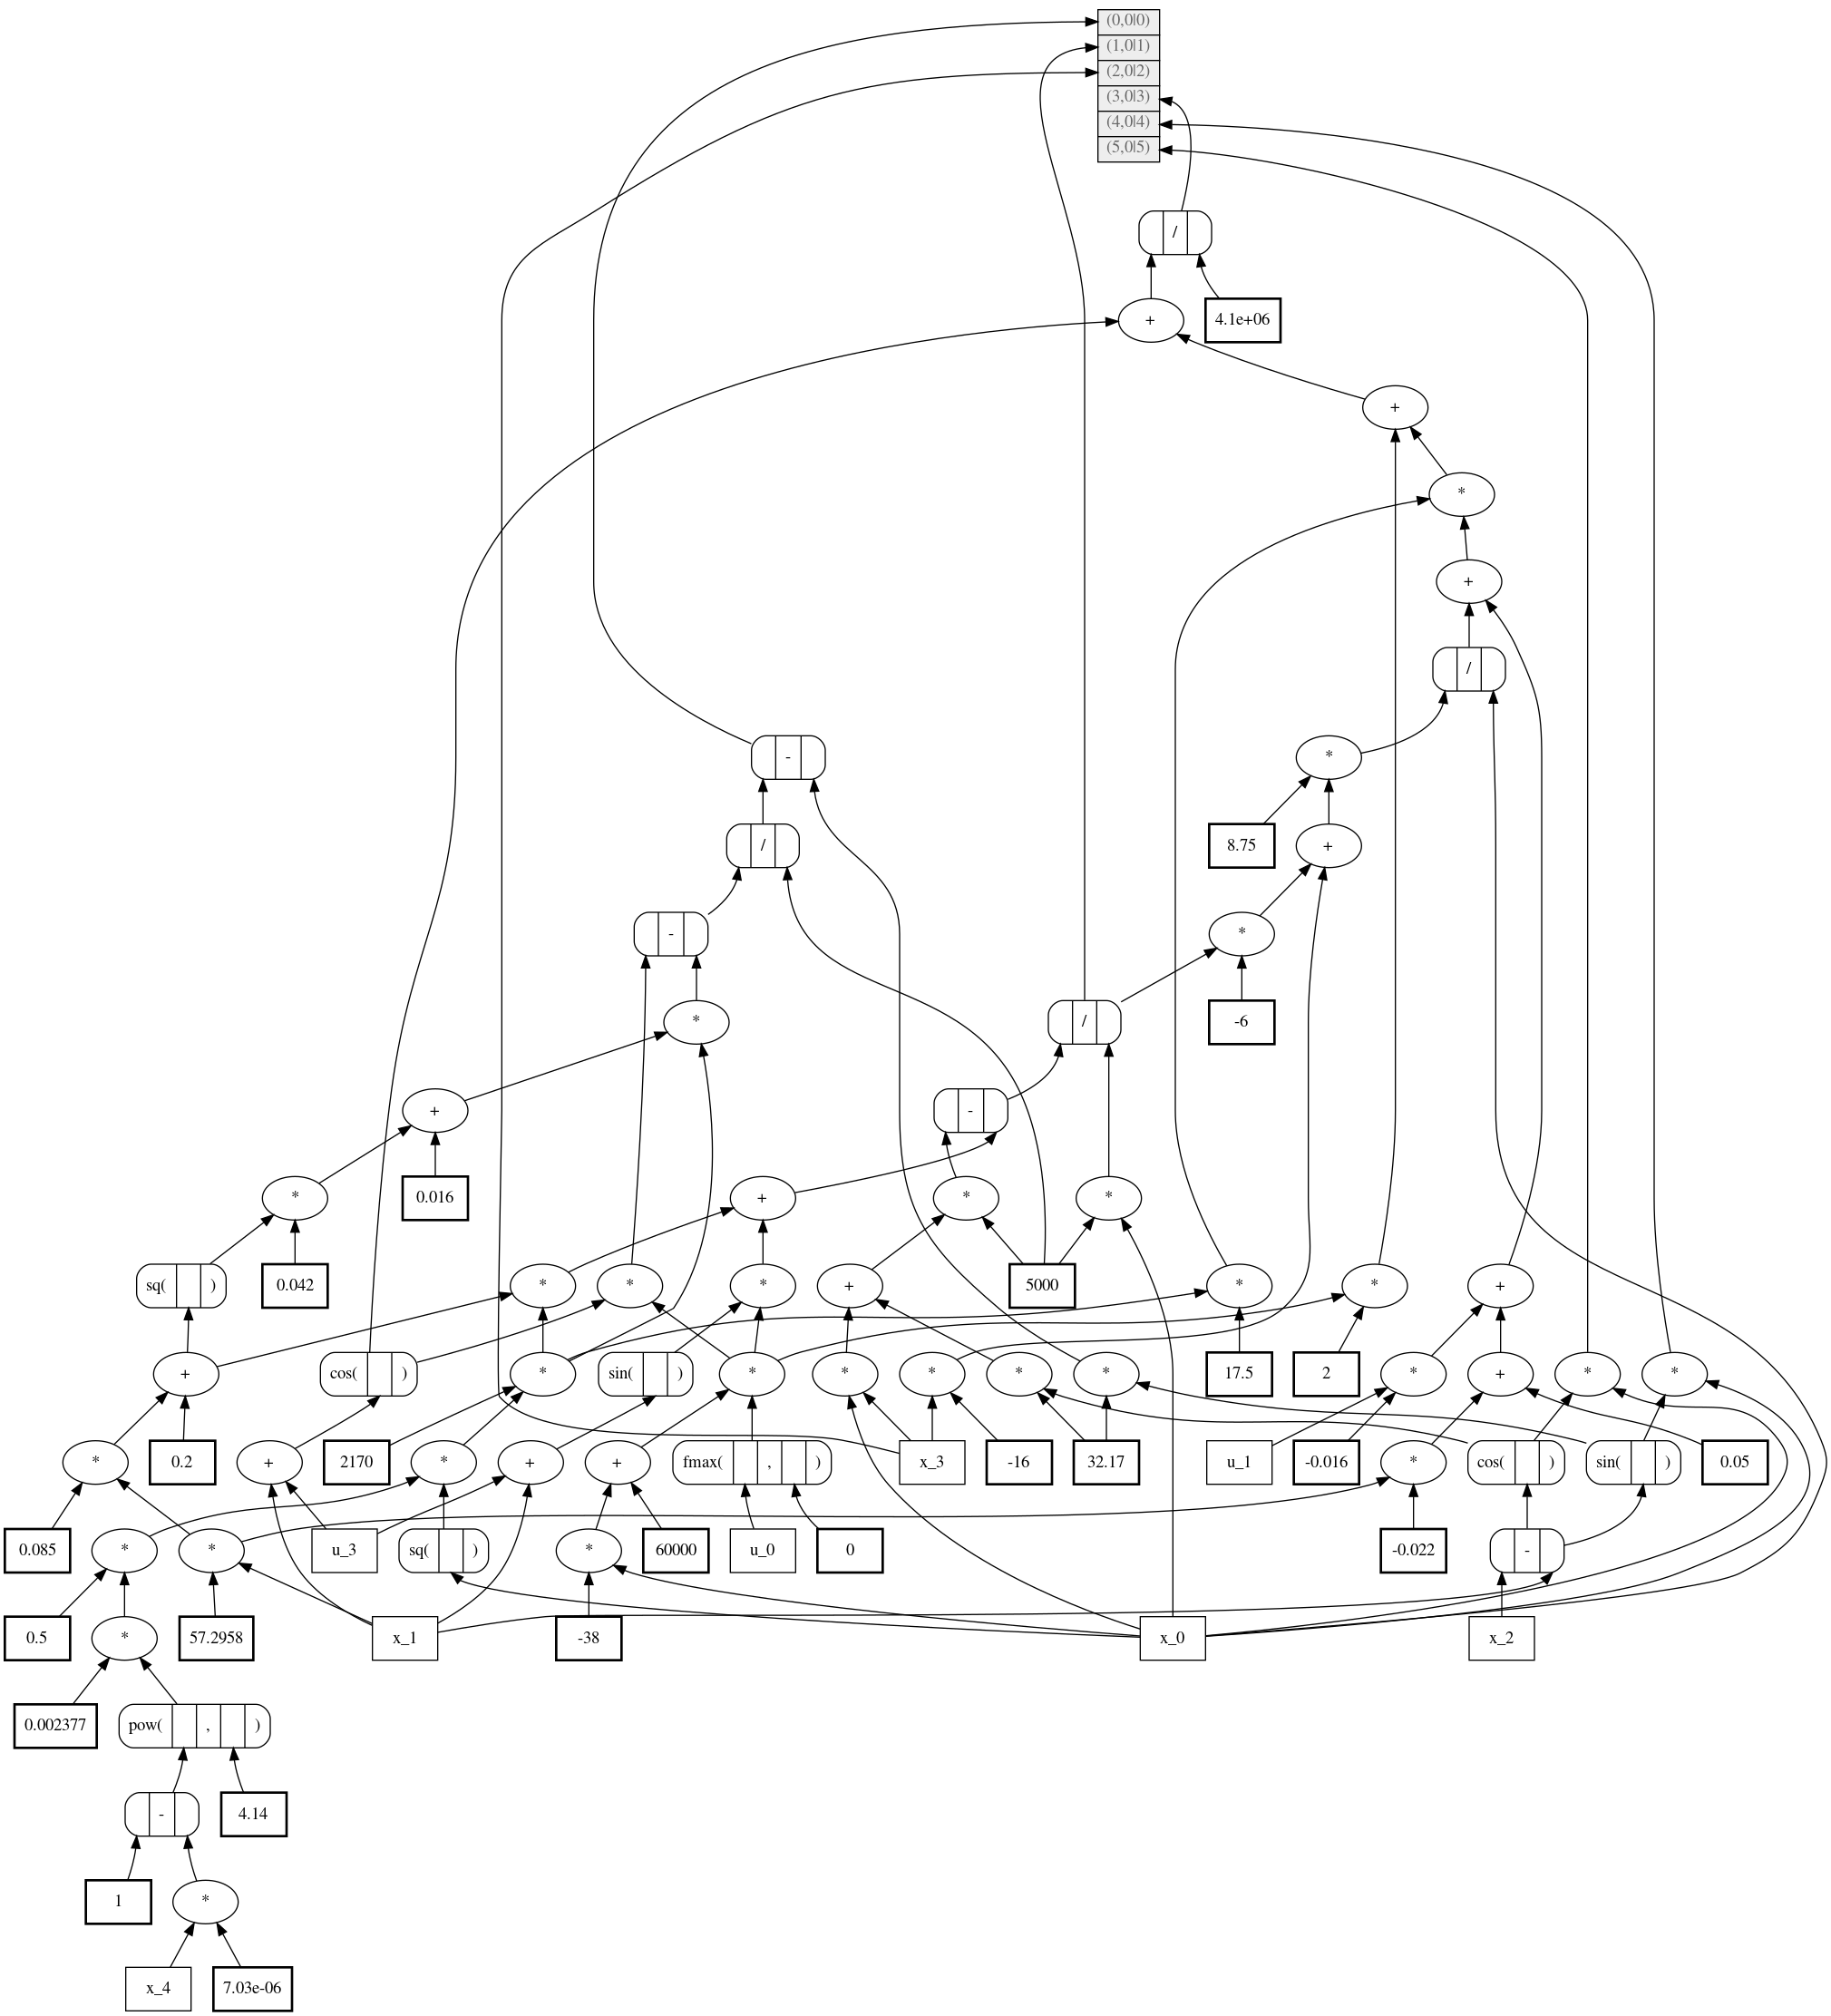

In [6]:
x = ca.SX.sym('x', 6)
u = ca.SX.sym('u', 4)
draw_graph(transportation_aircraft(x, u))

In [7]:
# Design Vector:
x_design = ca.SX.sym('x_design', 4)

# Input Parameter:
VT1 = 500
VT2 = 100
gearin = 0
gearout = 1
Height = 0

# Cost calculation:
cost1 = objective(x_design, VT1, Height, 0, 0)
cost2 = objective(x_design, VT2, Height, 0, 0)

# Variables to solve:
nlp1 = {'x': x_design, 'f': cost1}
S1 = nlpsol('S', 'ipopt', nlp1)
#print(S1)
nlp2 = {'x': x_design, 'f': cost2}
S2 = nlpsol('S', 'ipopt', nlp2)

In [8]:
x0 = [0.5, 0, 0, 0]

result1 = S1(x0=x0, lbg=0, ubg=0, ubx = [1, 60, np.deg2rad(30), 1], lbx = [-1, -60, -np.deg2rad(10), -1])
x_opt1 = result1['x']
print(result1)

print('x_opt: ', x_opt1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equa

In [9]:
result1.keys

<function dict.keys>

In [10]:
result2 = S2(x0=x0, lbg=0, ubg=0, ubx = [1, 60, np.deg2rad(30), 1], lbx = [-1, -60, -np.deg2rad(10), -1])
x_opt2 = result2['x']
print(result2)

print('x_opt: ', x_opt2)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [11]:
print('x_opt1: ', x_opt1)
print('x_opt2: ', x_opt2)

x_opt1:  [0.284171, 2.6523, 0.00735272, 0.0124526]
x_opt2:  [0.905978, -26.6308, 0.523599, 0.878738]


The initial guess $x0$ was throttle input $0.5$, elevator angle $0$ dgree, angle of attack at $0$ radian and tilt rotor angle at $0$ radian. Two different speed of aircraft, $500$ ft/s and $100$ ft/s, were evaluated at sea level condition. We see that the tilt rotor transport aircraft flies more optimally around $500$ ft/s, since it uses less amount of throttle. For $100$ ft/s, we observe that the required thrust is greater with tilt rotor angle at negative, meaning the rotor is tilted backward. We see higher instability around the second trim condition due to instability from aircraft mode.

Aircraft trim condition was tested again with different initial guess. The aircraft altitude is now changed to $10,000$ feet.

In [12]:
cost3 = objective(x_design, VT1, Height, 0, 0)
nlp3 = {'x': x_design, 'f': cost3}
S3 = nlpsol('S', 'ipopt', nlp3)

x0 = [0.75, 0, 0, 0]

result3 = S3(x0=x0, lbg=0, ubg=0, ubx = [1, 60, np.deg2rad(30), 1], lbx = [-1, -60, -np.deg2rad(10), -1])
x_opt3 = result3['x']
print(result3)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [13]:
cost4 = objective(x_design, VT2, Height, 0, 0)
nlp4 = {'x': x_design, 'f': cost4}
S4 = nlpsol('S', 'ipopt', nlp4)

x0 = [0.75, 0, 0, 0]

result4 = S4(x0=x0, lbg=0, ubg=0, ubx = [1, 60, np.deg2rad(30), 1], lbx = [-1, -60, -np.deg2rad(10), -1])
x_opt4 = result4['x']
print(result4)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [14]:
print('500: ', x_opt3)
print('100: ', x_opt4)

500:  [0.284171, 2.6523, 0.00735272, 0.0124526]
100:  [0.905978, -26.6308, 0.523599, 0.878738]


In [16]:
%matplotlib inline

import sys
sys.path.insert(0, '../python/casadi_f16')
import f16
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

from analysis import loop_analysis, rlocus, bode
plt.rcParams['figure.figsize'] = (10, 10)

This is a pitch controller with $VT = 500$ ft/s at sea level

In [21]:
x = ca.SX.sym('x', 6)
u = ca.SX.sym('u', 4)

A = ca.jacobian(transportation_aircraft(x, u), x)
B = ca.jacobian(transportation_aircraft(x, u), u)
C = ca.jacobian(x, x)
D = ca.jacobian(x, u)

f_ss = ca.Function('ss', [x, u], [A, B, C, D])
x0, u0 = constraint(x_opt1, VT1, Height, 0, 0)
sys1 = control.ss(*f_ss(x0, u0))

print(sys1)

A = [[-1.16168657e-02  1.96841557e+01 -3.21700000e+01  0.00000000e+00
   6.88138736e-05  0.00000000e+00]
 [-2.50042173e-04 -1.26069085e+00 -0.00000000e+00  1.00000000e+00
   1.77000547e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.62338969e-05 -3.10466001e+00  0.00000000e+00 -1.05953144e+00
  -3.46047587e-07  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e+02  5.00000000e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]

B = [[ 8.19839182e+00  0.00000000e+00  0.00000000e+00 -4.61475151e-02]
 [-3.24786494e-04  0.00000000e+00  0.00000000e+00 -4.65949684e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.00938513e-02 -4.40324756e-02  0.00000000e+00  1.34641792e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00

In [35]:
G = control.minreal(control.ss2tf(sys1[3, 1]))
G

0 states have been removed from the model



-0.04403 s^4 - 0.05602 s^3 - 0.0009006 s^2 - 7.388e-08 s - 7.272e-17
--------------------------------------------------------------------
  s^5 + 2.332 s^4 + 4.473 s^3 + 0.05832 s^2 + 0.02982 s + 5.708e-06

3 states have been removed from the model

8.806 s^3 + 28.67 s^2 + 30.93 s + 11.06
---------------------------------------
      s^4 + 2.322 s^3 + 4.444 s^2



(-7.342472743972881,
 0.3496415592368039,
 -2.4525433409996453,
 2.4525433409996453)

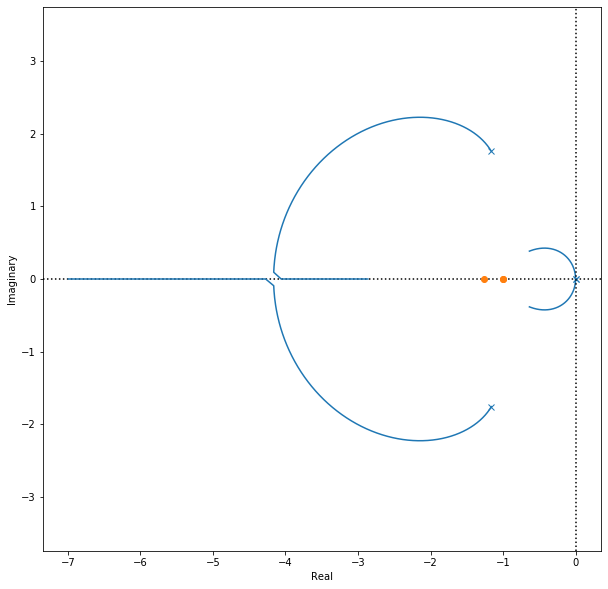

In [64]:
s = control.tf([1, 0], [0, 1])
H = (-200*(s+1)**2)/(s)**2
Go = control.minreal(H*sys1[3, 1], 1e-1)
print(Go)
control.rlocus(Go, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

0 states have been removed from the model

   8.806 s^3 + 28.67 s^2 + 30.93 s + 11.06
---------------------------------------------
s^4 + 11.13 s^3 + 33.12 s^2 + 30.93 s + 11.06



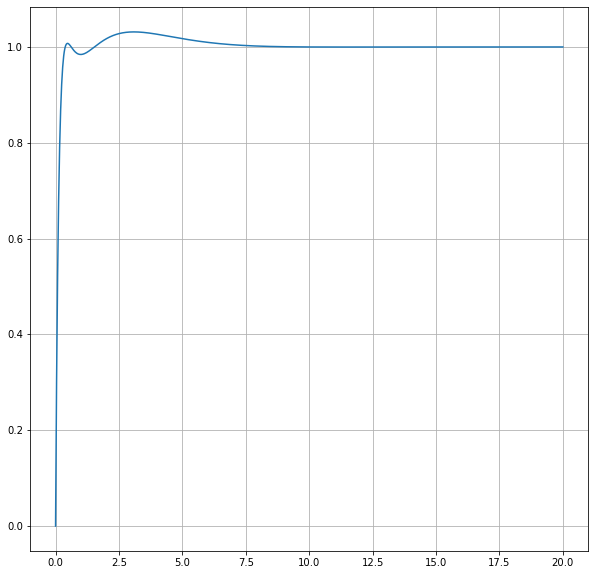

In [65]:
Gc = control.minreal(control.feedback(Go, 1))
print(Gc)
t, y = control.step_response(Gc, T = np.linspace(0, 20, 1000))
plt.plot(t, y)
plt.grid()

This is a pitch controller with $VT = 100$ ft/s at sea level

In [69]:
x0, u0 = constraint(x_opt2, VT2, Height, 0, 0)
sys2 = control.ss(*f_ss(x0, u0))

print(sys2)

A = [[-3.55717945e-02  1.63280891e+01 -3.21700000e+01  0.00000000e+00
   5.00844807e-05  0.00000000e+00]
 [-3.56369049e-03 -2.68279809e-01 -0.00000000e+00  1.00000000e+00
   4.12835731e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.61657652e-04 -1.23253773e-01  0.00000000e+00 -2.11906289e-01
   4.84275533e-07  0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+02  1.00000000e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]

B = [[ 1.88454137e+00  0.00000000e+00  0.00000000e+00 -1.00390460e+01]
 [-1.10808891e-01  0.00000000e+00  0.00000000e+00 -1.70735373e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.38185708e-02 -1.76129902e-03  0.00000000e+00  9.86484077e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00

In [70]:
G = control.minreal(control.ss2tf(sys2[3, 1]))
G

0 states have been removed from the model



-0.001761 s^4 - 0.0005352 s^3 - 0.00012 s^2 + 5.571e-09 s + 3.058e-19
---------------------------------------------------------------------
 s^5 + 0.5158 s^4 + 0.2558 s^3 + 0.01468 s^2 + 0.01191 s + 5.223e-07

2 states have been removed from the model

1.761 s^4 + 3.177 s^3 + 1.914 s^2 + 0.4812 s + 0.06753
-------------------------------------------------------
s^5 + 0.5157 s^4 + 0.2558 s^3 + 0.01467 s^2 + 0.01191 s



(-0.7979387798063552,
 0.07165501473343194,
 -1.3427074557204866,
 1.3427074557204866)

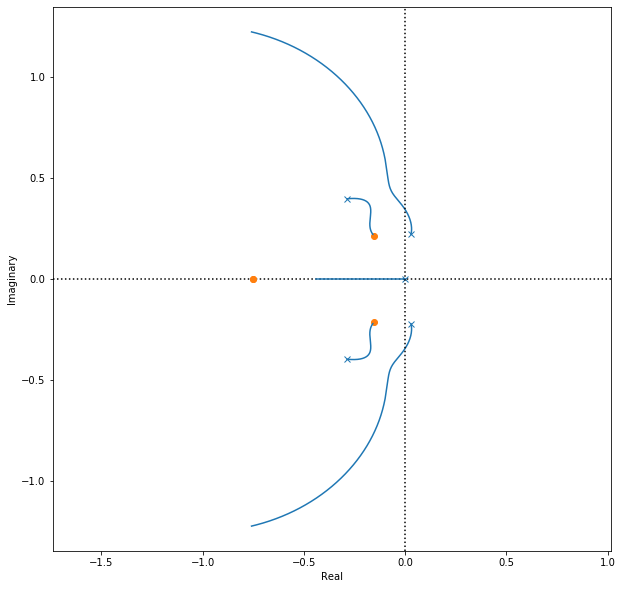

In [87]:
s = control.tf([1, 0], [0, 1])
H = (-1000*(s+0.75)**2)/(s)**2
Go = control.minreal(H*sys2[3, 1], 1e-1)
print(Go)
control.rlocus(Go, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

0 states have been removed from the model

   1.761 s^4 + 3.177 s^3 + 1.914 s^2 + 0.4812 s + 0.06753
------------------------------------------------------------
s^5 + 2.277 s^4 + 3.433 s^3 + 1.928 s^2 + 0.4931 s + 0.06753



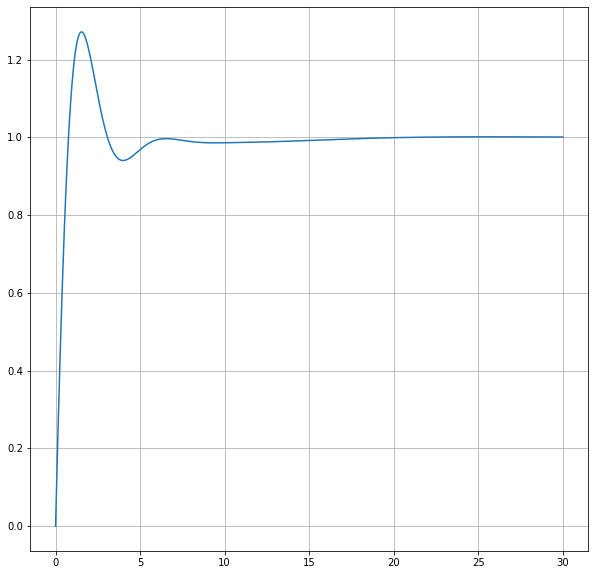

In [89]:
Gc = control.minreal(control.feedback(Go, 1))
print(Gc)
t, y = control.step_response(Gc, T = np.linspace(0, 30, 1000))
plt.plot(t, y)
plt.grid()